In [14]:
#from Tools import *
import numpy as np
import seaborn as sns
import pandas as pd
from BayesianInference import *
from random import Random
import random
from scipy.interpolate import interp1d
from scipy.stats import rv_continuous
from astropy.io import ascii
import emcee
import pathos.multiprocessing as multiproc
from multiprocessing import Pool
import corner
from IPython.display import display, Math
from palettable.cartocolors.qualitative import Antique_3
from matplotlib.colors import ListedColormap
import seaborn as sns
import glob 
import warnings

In [15]:
c=ascii.read("../../A-Catalogs/Binospec-Candels.cat")

## MCMC Functions

In [21]:
def Likelihood(fesc,dfesc,A,Wo):
    """
    Likelihood : Probability of having a certain value of EW given the exponential parameters A and Wo

    Args:
        ew: Equivalent widths observed
        A : Parameter exponential (should depend on our other observables, such as uvslope and muv)
        Wo : Parameter exponential (should depend on our other observables, such as uvslope and muv)
    """
    if Wo<0:
        A=0
    A=1
    dEW_2 = dfesc**2.
    p1 = (1. - A) * np.exp(-0.5 * fesc**2./dEW_2) / np.sqrt(2.*np.pi) / dfesc
    X  = (dEW_2/Wo - fesc) / np.sqrt(2.) / dfesc
    p2 = 0.5 * A / Wo * np.exp(0.5*(dEW_2 - 2*fesc*Wo)/Wo**2.)*scipy.special.erfc(X)
    p = p1 + p2
    return p

def LikUp(wtab,dew,A,Wo):
        like = Likelihood(wtab,dew,A,Wo)
        return integrate.trapz(like,wtab)

def LikLow(wtab,dew,A,Wo):
        like = Likelihood(wtab,dew,A,Wo)
        return integrate.trapz(like,wtab)


def Posterior(fesc,dfesc,A,Wo,Detection_type,wtab):
    """
    """
    probLike=[]
    for i in range(0,len(Detection_type)):
        if Detection_type[i]=="LyaHa":
            p   =   Likelihood(fesc[i],dfesc[i],A,Wo)
        if Detection_type[i]=="Ha":
            p   =   LikUp(wtab[i],dfesc[i],A,Wo)
        if Detection_type[i]=="Lya":
            p   =   LikLow(wtab[i],dfesc[i],A,Wo)
        if np.isnan(p)==True:
            continue

        probLike.append(p)
        
    return np.array(probLike)


def log_prior(theta):
    # I can put priors here or in the equation in the BInf object 
    A,Wo= theta
    A=1
    #print(A,W)
    if (A >= 0.) and (A <=1.0) and (Wo > -1.).all()and (Wo < 1.).all():# and (W < 500.).all():
        return 0.0 

    return -np.inf

def log_likelihood(theta,y,yerr,Detection_type,wtab):
    A,Wo= theta
    A=1
    model = Posterior(y,yerr,A,10**Wo,Detection_type,wtab) # Does thus have to be exp, so it gets outside the logaritm?
    return np.sum(np.log(model))


def log_probability(theta, y, yerr,Detection_type,wtab):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    lL=log_likelihood(theta, y, yerr,Detection_type,wtab)
    #print(lL)
    if np.isnan(lL)==True:
        return -np.inf
    else:
        return lp + lL

## Generate Mock EW_obs and run code

In [22]:
def Muv_mock(mean,std_dev,N_gals):
    values = np.random.normal(mean, std_dev, N_gals)
    mask= (values<-18.5) & (values>-23)
    return values[mask]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.3019951720402016


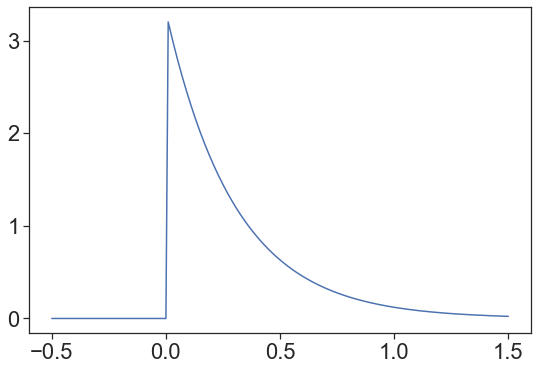

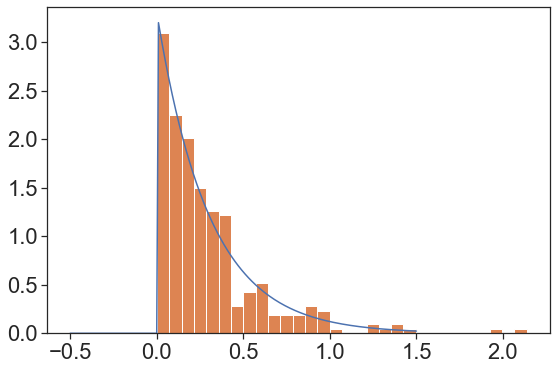

/Users/gonzalo/Desktop/Code/Gonzalo_Binospec/A-Project/D-EWModel/Simple PhotometryRebuild 15 May fesc Wonly/BayesianInference.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.wtab=np.array(wtabs)


In [23]:
%load_ext autoreload
%autoreload
sns.set_theme(style="ticks",font_scale=2)
plt.rcParams["figure.figsize"] = (9,6.)

N=300
BInf=BayesInf()
mockParamsA=1
mockParamsW=-0.52
fesc,prob,A,W=BInf.GenerateMockData(mockParamsA,mockParamsW)
plt.plot(fesc,prob)
plt.show()
intrinsicFesc = [RandomSampler(mockParamsA,mockParamsW) for i in range(N)]

plt.plot(fesc,prob)
plt.hist(intrinsicFesc,bins=30,density=True)
plt.show()

BInf.fesc = intrinsicFesc
Noise=0.05
fesc_obs=BInf.RandomDrawEW(noise=Noise)
BInf.fesc_obs=np.array(fesc_obs)
BInf.noise=Noise
BInf.dfesc=np.array([Noise for i in range(len(intrinsicFesc))])
dfesc=BInf.dfesc


Detection_type=BInf.Classify_fesc()
wtab=BInf.GenerateWtab_real()

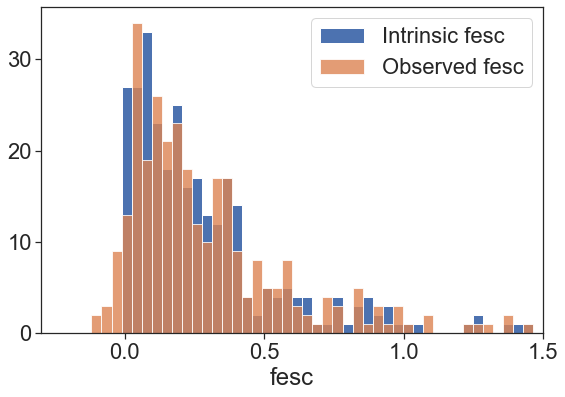

In [24]:
plt.hist(intrinsicFesc,bins=50,range=[-0.3,1.5],label="Intrinsic fesc")
plt.hist(fesc_obs,bins=50,range=[-0.3,1.5],alpha=0.8,label="Observed fesc")
plt.xlim(-0.3,1.5)
plt.xlabel("fesc")
plt.legend()
plt.show()

In [26]:
import seaborn as sns
%load_ext autoreload
%autoreload
# Set the seaborn theme and font scale
sns.set_theme(style="ticks",font_scale=2)
plt.rcParams["figure.figsize"] = (9,6.)

# Rest of your code
Sample_size=[300]
Resulting_Dif_per_N=[]
for N in Sample_size:
    Resulting_Dif=[]
    for ii in range(0,1):
########
        Muv=Muv_mock(-20,1,N)   
        BInf=BayesInf()
        BInf.Muv=Muv
        mockParamsA=0.8
        mockParamsW=-0.5 #logscale
        fesc,prob,A,W=BInf.GenerateMockData(mockParamsA,mockParamsW)
        intrinsicFesc = [RandomSampler(mockParamsA,mockParamsW) for i in range(N)]
        BInf.fesc = intrinsicFesc
#########
        Noise=0.05
        fesc_obs=BInf.RandomDrawEW(noise=Noise)
        BInf.fesc_obs=np.array(fesc_obs)
        BInf.noise=Noise
        BInf.dfesc=np.array([Noise for i in range(len(intrinsicFesc))])
        dfesc=BInf.dfesc
        Detection_type=BInf.Classify_fesc()
        wtab=BInf.GenerateWtab_real()
        #plt.hist(fesc_obs,bins=100,range=(-0.1,1.5),alpha=0.5)
        #plt.xlabel('fesc_obs')
        #plt.show()

        steps=2500
        nwalkers=15
        inValuesA=[0.5]
        inValuesW=[-0.3]
        inValues=inValuesA+inValuesW
        pos = inValues+ [0.5,0.3] * np.random.randn(nwalkers,len(inValues) )
        nwalkers, ndim = np.shape(pos)



        sampler = emcee.EnsembleSampler(
            nwalkers, ndim, log_probability, args=(fesc_obs,dfesc,Detection_type,wtab)
        )
        sampler.run_mcmc(pos, steps, progress=True)


        dis=500
        labels = ["A","log10Wo"]
        samples = sampler.get_chain(discard=dis)
        logProb=sampler.get_log_prob(discard=dis)
        maskWalkers=[False if np.isinf(logProb[steps-dis-10,i]) else True for i in range(0,nwalkers)]
        samples=np.array([s[maskWalkers] for s in samples])


        ndim=len(labels)
        samples = sampler.get_chain(discard=dis)
        samples=np.array([s[maskWalkers] for s in samples])
        samples=samples.reshape(np.shape(samples)[0]*np.shape(samples)[1],np.shape(samples)[2])

        #fig = corner.corner(
        #    samples, labels=labels,quantiles=[.16,.50,.84],truths=[mockParamsA,mockParamsW]
        #)
        #plt.show()
        
        results=[]
        r16,r84=[],[]
        for i in range(ndim):
            mcmc = np.percentile(samples[:, i], [16, 50, 84])
            results.append(mcmc[1])
            r16.append(mcmc[0])
            r84.append(mcmc[2])
        #    q = np.diff(mcmc)
        #    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
        #    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        #    display(Math(txt))

        Dif_A =(results[0]-mockParamsA)/mockParamsA
        Dif_Wo  =(results[1]-mockParamsW)/mockParamsW

        print("Dif_A",100*Dif_A,"%")
        print("Dif_Wo",100*Dif_Wo,"%")  

        Resulting_Dif.append([Dif_A,Dif_Wo])
    Resulting_Dif_per_N.append(Resulting_Dif)
    np.save("results_accuracy_uplim/fesc/"+str(N)+"_samples_LyaHaHa",Resulting_Dif)
Resulting_Dif_per_N=np.array(Resulting_Dif_per_N)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.31622776601683794


  0%|          | 0/2500 [00:00<?, ?it/s]/Users/gonzalo/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 2500/2500 [02:34<00:00, 16.23it/s]

Dif_A 3.667082488717941e+33 %
Dif_Wo 16.317878182543065 %


In [12]:
import natsort

f = natsort.natsorted(glob.glob("results_accuracy_uplim/fesc/*_LyaHaHa*"))
means=[]
stds=[]
for i in range(0,len(f)):
    print(f[i])
    Resulting_Dif=np.load(f[i])
    print(np.mean(Resulting_Dif,axis=0))
    print(np.std(Resulting_Dif,axis=0))
    means.append(np.mean(Resulting_Dif,axis=0))
    stds.append(np.std(Resulting_Dif,axis=0))
    print("")

means=np.transpose(means)
stds=np.transpose(stds)


results_accuracy_uplim/fesc/72_samples_LyaHaHa.npy
[-0.36907262  0.03960076]
[0.11455441 0.144252  ]

results_accuracy_uplim/fesc/300_samples_LyaHaHa.npy
[-0.41066867  0.06438461]
[0.03920566 0.0895677 ]

results_accuracy_uplim/fesc/1000_samples_LyaHaHa.npy
[-0.42086609  0.04184331]
[0.02336582 0.03946328]



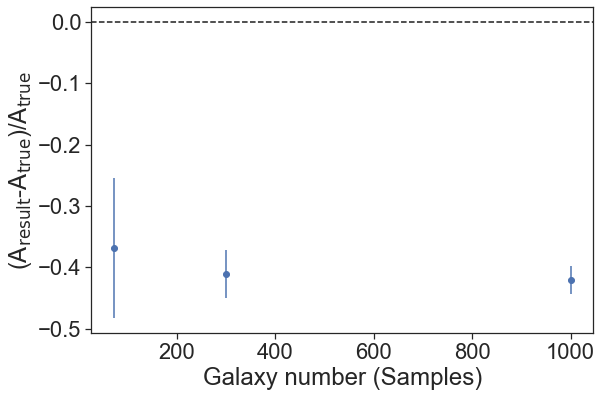

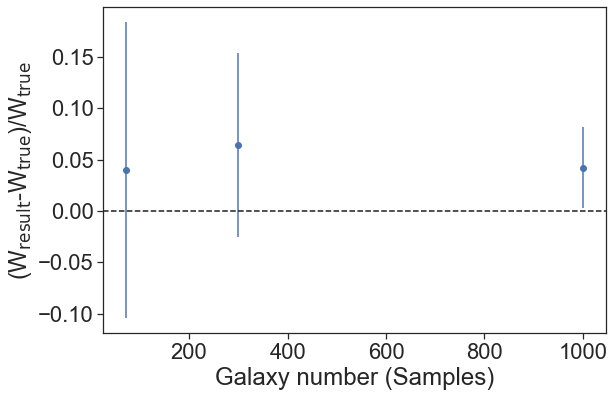

In [13]:
sns.set_theme(style="ticks",font_scale=2)
plt.rcParams["figure.figsize"] = (9,6.)
samples_sizes=[72,300,1000]
plt.errorbar(samples_sizes,means[0],yerr=stds[0],label="Auv",fmt="o")
plt.ylabel(r"(A$_{\mathrm{result}}$-A$_{\mathrm{true}}$)/A$_{\mathrm{true}}$")
plt.axhline(0,ls="--",c="k")
plt.xlabel("Galaxy number (Samples)")
plt.show()

plt.errorbar(samples_sizes,means[1],yerr=stds[1],label="Ac",fmt="o")
plt.ylabel(r"(W$_{\mathrm{result}}$-W$_{\mathrm{true}}$)/W$_{\mathrm{true}}$")
plt.xlabel("Galaxy number (Samples)")
plt.axhline(0,ls="--",c="k")
plt.show()

